In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt


# N is the number of configurations and S store all states.

N = 1000
torch.manual_seed(1)
S = 2 * torch.randint(low=0, high=2, size=(N, 16)) - 1

In [2]:
# ss, tt are step size and train times.
# BV and WV store variables to learn.
# initial setting for (BV, WV) is (0.1,...;1.4,...)

(ss, tt) = (0.01, 500)
BV = torch.full((1, 5), 0.1, requires_grad = True)
WV = torch.full((1, 20), 1.4, requires_grad = True)
optimizer = torch.optim.Adam([BV, WV], lr = ss)


# pe is the function used in criterion
def pe(m, a, b):
    PE = 2 * torch.cosh(
        m[a][b] + 1j * m[a - 1][b - 1] * m[a - 2][b - 2] + 1j * m[a - 1][b + 1] * m[a - 2][b + 2]
        + 1j * m[a + 1][b + 1] * m[a + 2][b + 2] + 1j * m[a + 1][b - 1] * m[a + 2][b - 2])
    return PE


def criterion(bv, wv, s):
    # Assign all information into M to simplify the calculation using pe
    M = torch.zeros(13, 13)
    M[6][6] = bv[0][4]
    for i in range(2):
        for j in range(2):
          M[2 + 8 * i][2 + 8 * j] = bv[0][2 * i + j]
          M[5 + 2 * i][5 + 2 * j] = wv[0][16 + 2 * i + j]
          for p in range(2):
            for q in range(2):
              M[4 * i + 2 + 4 * j + 2 * p - 1][6 - 4 * i + 4 * j + 2 * q - 1] = torch.pi / 4
              M[2 + 8 * i + 2 * p -1][2 + 8 * j + 2 * q -1] = wv[0][8 * i + 4 * j + 2 * p + q]

    # In each configuration k, assign S[k] to M and calculate V[k]
    V = torch.empty((N,), dtype=torch.complex64)

    for k in range(N):
        # clone M to M1 M2, and flip 4 qubits in M2
        M1 = M.clone()
        M2 = M.clone()
        for i in range(4):
            for j in range(4):
                M1[4 * i][4 * j] = s[k][4 * i + j]
        for i in range(4):
            for j in range(4):
                M2[4 * i][4 * j] = s[k][4 * i + j]
        for i in (1, 2):
            for j in (1, 2):
                M2[4 * i][4 * j] = -s[k][4 * i + j]
        # calculate the sub-cost function for each configuration k
        V[k] = pe(M1, 6, 6) * pe(M1, 2, 2) * pe(M1, 2, 10) * pe(M1, 10, 2) * pe(M1, 10, 10) \
            * pe(M1, 6, 2) * pe(M1, 2, 6) * pe(M1, 10, 6) * pe(M1, 6, 10) - pe(M2, 6, 6) \
            * pe(M2, 2, 2) * pe(M2, 2, 10) * pe(M2, 10, 2) * pe(M2, 10, 10) \
            * pe(M2, 6, 2) * pe(M2, 2, 6) * pe(M2, 10, 6) * pe(M2, 6, 10)
    v = torch.norm(V)
    return v


# Stochastic gradient descent
COST = []
ABV = [[],[],[],[],[]]
AWV = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for h in range(tt):
    cost = criterion(BV, WV, S)
    COST.append(cost.tolist())
    for p in range(5):
      ABV[p].append(BV[0][p].tolist())
    for q in range(20):
      AWV[q].append(WV[0][q].tolist())
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

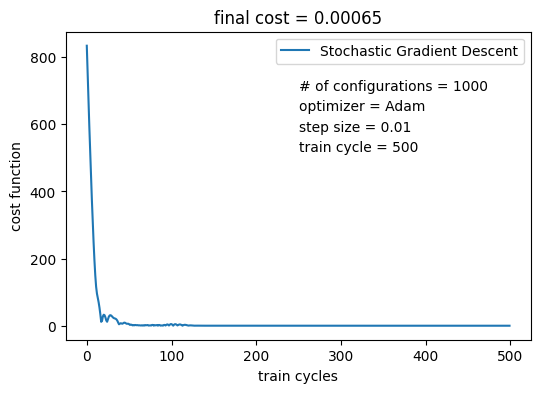

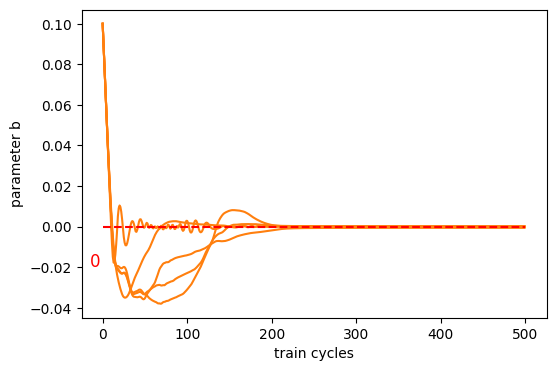

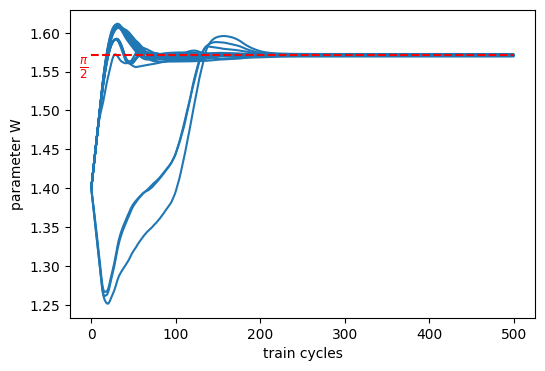

In [6]:
# Visualize results: Cost
fig1 = plt.figure(figsize=(6, 4))
plt.plot(COST, label="Stochastic Gradient Descent")
plt.title("final cost = %.5f" % cost.data.item())
plt.text(250, 700, "# of configurations = %i" % N)
plt.text(250, 640, "optimizer = Adam")
plt.text(250, 580, "step size = %.2f" % ss)
plt.text(250, 520, "train cycle = %i" % tt)
plt.xlabel("train cycles")
plt.ylabel("cost function")
plt.legend()
plt.show()

# Visualize results: BV
fig2 = plt.figure(figsize=(6, 4))
for p in range(5):
  plt.plot(ABV[p], color='tab:orange')
plt.plot ([0, 500], [0.0, 0.0], 'r--', linewidth=1.5)
plt.text (-15, -0.02, '0', color = 'r', fontsize = 12)
plt.xlabel("train cycles")
plt.ylabel("parameter b")
plt.show()

# Visualize results: WV
fig3 = plt.figure(figsize=(6, 4))
for q in range(20):
  plt.plot(AWV[q], color='tab:blue')
plt.plot ([0, 500], [1.5708, 1.5708], 'r--', linewidth=1.5)
plt.text (-15, 1.55, r'$\frac{\pi}{2}$', color = 'r', fontsize = 12)
plt.xlabel("train cycles")
plt.ylabel("parameter W")
plt.show()